## Setup

### Import packages

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline

from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold



from wordcloud import WordCloud
from matplotlib import pyplot as plt

/anaconda3/envs/LP-NLP/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/anaconda3/envs/LP-NLP/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Load data

In [2]:
df = pd.read_csv("spam.csv", encoding="L1")
df = df.rename(
    columns = {
        "v1": "label",
        "v2": "text"
    }
)

df = df[["label", "text"]]

labels = df["label"].values
text = df["text"].values

### Build visualization functions

In [3]:
def make_word_cloud(words_array):
    
    """
    Takes an array of text and makes a word cloud from it.
    """
    
    words_str = " ".join([c.lower() for c in words_array])
    wordcloud = WordCloud().generate(words_str)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
    return

def word_cloud_from_df(df, label):
    
    """
    Takes a DataFrame with columns labels and text.
    Visualizes all the text for a label as a word cloud.
    """
    
    words_array = df.loc[df["label"]==label, "text"].values
    make_word_cloud(words_array)
    
    return

### Build other functions and classes

In [4]:
class DenseTransformer(TransformerMixin):
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None, **fit_params):
        return X.todense()        

## Visualize the data

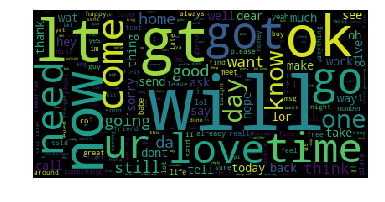

In [5]:
word_cloud_from_df(df, "ham")

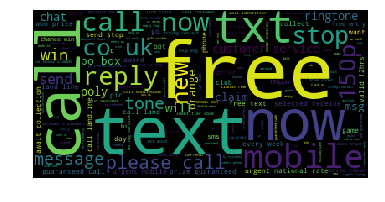

In [6]:
word_cloud_from_df(df, "spam")

## Process the data for learning

In [7]:
X = text
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [8]:
cv = CountVectorizer()

cv.fit(X_train)
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

## Word counts as features

### Naive Bayes

In [9]:
# note: CountVectorizer returns a sparse matrix, while GaussianNB requires a dense matrix
cv_nb = Pipeline([
    ("count_vectorizer", CountVectorizer()),
    ("dense_transformer",  DenseTransformer()),
    ("naive_bayes", GaussianNB())
])

In [10]:
%%time
cv_nb.fit(X_train, y_train)

CPU times: user 1.69 s, sys: 346 ms, total: 2.04 s
Wall time: 926 ms


Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...rmer', <__main__.DenseTransformer object at 0x1091f6fd0>), ('naive_bayes', GaussianNB(priors=None))])

In [11]:
cv_nb_train_acc = cv_nb.score(X_train, y_train)
cv_nb_test_acc = cv_nb.score(X_test, y_test)

print(f"Word Count - Naive Bayes Train Accuracy {cv_nb_train_acc}")
print(f"Word Count - Naive Bayes Test Accuracy {cv_nb_test_acc}")

Word Count - Naive Bayes Train Accuracy 0.9557310361330462
Word Count - Naive Bayes Test Accuracy 0.9124192390524049


### Ada Boost

In [12]:
# note: AdaBoostClassifier() does not require a dense matrix and runs significantly faster with a sparse matrix
cv_ab = Pipeline([
    ("count_vectorizer", CountVectorizer()),
    ("ada_boost", AdaBoostClassifier())
])

In [13]:
%%time
cv_ab.fit(X_train, y_train)

CPU times: user 647 ms, sys: 4.3 ms, total: 651 ms
Wall time: 400 ms


Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...m='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])

In [14]:
cv_ab_train_acc = cv_ab.score(X_train, y_train)
cv_ab_test_acc = cv_ab.score(X_test, y_test)

print(f"Word Count - Ada Boost Train Accuracy {cv_ab_train_acc}")
print(f"Word Count - Ada Boost Test Accuracy {cv_ab_test_acc}")

Word Count - Ada Boost Train Accuracy 0.9765494137353434
Word Count - Ada Boost Test Accuracy 0.9727207465900933


## TF-IDF as Features

### Naive Bayes

In [15]:
# note: CountVectorizer -> TfidfTransformer returns a sparse matrix, while GaussianNB requires a dense matrix
tfidf_nb = Pipeline([
    ("count_vectorizer", CountVectorizer()),
    ("tfidf_transformer",  TfidfTransformer()),
    ("dense_transformer",  DenseTransformer()),
    ("naive_bayes", GaussianNB())
])

In [16]:
%%time
tfidf_nb.fit(X_train, y_train)

CPU times: user 1.5 s, sys: 339 ms, total: 1.84 s
Wall time: 875 ms


Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...mer', <__main__.DenseTransformer object at 0x1a1b804128>), ('naive_bayes', GaussianNB(priors=None))])

In [17]:
tfidf_nb_train_acc = tfidf_nb.score(X_train, y_train)
tfidf_nb_test_acc = tfidf_nb.score(X_test, y_test)

print(f"TF-IDF - Naive Bayes Train Accuracy {tfidf_nb_train_acc}")
print(f"TF-IDF - Naive Bayes Test Accuracy {tfidf_nb_test_acc}")

TF-IDF - Naive Bayes Train Accuracy 0.9557310361330462
TF-IDF - Naive Bayes Test Accuracy 0.9131371141421393


### Ada Boost

In [18]:
# note: AdaBoostClassifier() does not require a dense matrix and runs significantly faster with a sparse matrix
tfidf_ab = Pipeline([
    ("count_vectorizer", CountVectorizer()),
    ("tfidf_transformer",  TfidfTransformer()),
    ("ada_boost", AdaBoostClassifier())
])

In [19]:
%%time
tfidf_ab.fit(X_train, y_train)

CPU times: user 842 ms, sys: 10.4 ms, total: 853 ms
Wall time: 552 ms


Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...m='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])

In [20]:
tfidf_ab_train_acc = tfidf_ab.score(X_train, y_train)
tfidf_ab_test_acc = tfidf_ab.score(X_test, y_test)

print(f"TF-IDF - Ada Boost Train Accuracy {tfidf_ab_train_acc}")
print(f"TF-IDF - Ada Boost Test Accuracy {tfidf_ab_test_acc}")

TF-IDF - Ada Boost Train Accuracy 0.9839674563292654
TF-IDF - Ada Boost Test Accuracy 0.9763101220387652


## Cross Validate

In [21]:
models = {
    "Word Count Naive Bayes": cv_nb,
    "Word Count Ada Boost": cv_ab,
    "TF-IDF Naive Bayes": tfidf_nb,
    "TF-IDF Ada Boost": tfidf_ab
}



kf = KFold(n_splits=6, shuffle=True, random_state=66)

for key in models:

    scores = cross_validate(models[key], X, y, cv=kf)
    print(key)
    print("fit_time", scores["fit_time"])
    print("test_score", scores["test_score"])
    print()

Word Count Naive Bayes
fit_time [1.12695098 1.05661321 1.02353263 1.0212419  1.04895997 1.06075191]
test_score [0.91496233 0.90527449 0.90635091 0.8977395  0.91271552 0.89116379]

Word Count Ada Boost
fit_time [0.43412423 0.42418694 0.41522598 0.41787028 0.41476202 0.41679597]
test_score [0.97739505 0.97308934 0.97631862 0.96340151 0.96767241 0.98060345]

TF-IDF Naive Bayes
fit_time [1.00329018 0.98869205 1.0235281  1.00261593 0.99340701 0.99934983]
test_score [0.90850377 0.90204521 0.89989236 0.89558665 0.91056034 0.89008621]

TF-IDF Ada Boost
fit_time [0.59147191 1.1845901  0.57402587 0.57479692 0.57648802 0.57440805]
test_score [0.97739505 0.97739505 0.96555436 0.97201292 0.96443966 0.97737069]



## Prediction

We'll go with Word Count Ada Boost because its preformance is esentially tied with TF-IDF Ada boost.

In [22]:
cv_ab.predict(["This is ham!"])

array(['ham'], dtype=object)

In [23]:
cv_ab.predict(["XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here"])

array(['spam'], dtype=object)